In [33]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from scipy.spatial.transform import Rotation as R

from pgmpy.models import DiscreteBayesianNetwork 
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
from pgmpy.factors.discrete import TabularCPD

Wczytanie danych z czujników IMU, prędkości po filtracji oraz pozycji GNSS. Obliczenie współczynników przeliczeniowych stopni geograficznych na metry.

In [34]:
df_imu = pd.read_csv('imu_data.csv')
df_vel = pd.read_csv('filter_velocity.csv')
df_pose = pd.read_csv('gnss_pose.csv')

METERS_PER_DEG_LAT = 111132.0

mean_lat = df_pose['pose.position.x'].mean()
METERS_PER_DEG_LON = 111132.0 * np.cos(np.radians(mean_lat))

print(f"METERS_PER_DEG_LAT: {METERS_PER_DEG_LAT}\nMETERS_PER_DEG_LON: {METERS_PER_DEG_LON}")

METERS_PER_DEG_LAT: 111132.0
METERS_PER_DEG_LON: 71386.11581149495


### IMU quaternions to Euler 

Przekształcenie orientacji z postaci kwaternionów do kątów Eulera (roll, pitch) oraz wyznaczenie całkowitego przyspieszenia na podstawie składowych z akcelerometru.

In [35]:
quants = df_imu[['orientation.x', 'orientation.y', 'orientation.z', 'orientation.w']].values

r = R.from_quat(quants)
euler = r.as_euler('xyz', degrees=True)

df_imu['roll'] = np.abs(euler[:, 0])
df_imu['pitch'] = np.abs(euler[:, 1])

df_imu['acc_total'] = np.sqrt(
    df_imu['linear_acceleration.x']**2 +
    df_imu['linear_acceleration.y']**2 +
    df_imu['linear_acceleration.z']**2
)
print(f"shape: {df_imu.shape}")
df_imu.head(2)

shape: (2916, 17)


,time,orientation.x,orientation.y,orientation.z,orientation.w,orientation_covariance,angular_velocity.x,angular_velocity.y,angular_velocity.z,angular_velocity_covariance,linear_acceleration.x,linear_acceleration.y,linear_acceleration.z,linear_acceleration_covariance,roll,pitch,acc_total
0,1.354145,-0.002686,-0.00406,0.975792,0.218647,[0. 0. 0. 0. 0. 0. 0. 0. 0.],0.164361,-0.017460,-0.099404,[0. 0. 0. 0. 0. 0. 0. 0. 0.],-0.300894,-0.180785,9.659451,[0. 0. 0. 0. 0. 0. 0. 0. 0.],0.521309,0.198615,9.665827
1,1.374145,-0.002217,-0.00253,0.975581,0.219617,[0. 0. 0. 0. 0. 0. 0. 0. 0.],0.149255,-0.016467,-0.102909,[0. 0. 0. 0. 0. 0. 0. 0. 0.],-0.526813,-0.065190,9.931564,[0. 0. 0. 0. 0. 0. 0. 0. 0.],0.338681,0.184126,9.945740


### Velocity & GNSS fusion

Obliczenie modułu wektora prędkości filtrowanej oraz estymacja prędkości na podstawie danych GNSS z wykorzystaniem przyrostów pozycji i czasu.


In [ ]:
df_vel['speed_filter'] = np.sqrt(df_vel['vector.x']**2 + df_vel['vector.y']**2 + df_vel['vector.z']**2)
    

df_pose['dt'] = df_pose['time'].diff()

d_lat_m = df_pose['pose.position.x'].diff() * METERS_PER_DEG_LAT
d_lon_m = df_pose['pose.position.y'].diff() * METERS_PER_DEG_LON

df_pose['dist'] = np.sqrt(d_lat_m**2 + d_lon_m**2)

df_pose['speed_gps'] = df_pose['dist'] / df_pose['dt']
df_pose['speed_gps'] = df_pose['speed_gps'].fillna(0)

print(f"shape: {df_pose.shape}")
df_pose.head(5)


shape: (2912, 11)


,time,pose.position.x,pose.position.y,pose.position.z,pose.orientation.x,pose.orientation.y,pose.orientation.z,pose.orientation.w,dt,dist,speed_gps
0,1.434146,50.032473,19.995206,237.308843,-0.000907,0.001389,0.974938,0.222472,NaN,NaN,0.000000
1,1.454146,50.032473,19.995206,237.308914,-0.000508,0.002433,0.974725,0.223394,0.02,0.003014,0.150695
2,1.474146,50.032473,19.995206,237.308942,-0.000156,0.003312,0.974515,0.224298,0.02,0.003026,0.151321
3,1.494146,50.032473,19.995206,237.308926,0.000150,0.004017,0.974305,0.225196,0.02,0.003025,0.151234
4,1.514146,50.032473,19.995206,237.308888,0.000444,0.004515,0.974097,0.226086,0.02,0.003052,0.152599


### Data merge

Synchronizacja danych z IMU, prędkości filtrowanej oraz GNSS na podstawie znacznika czasu z wykorzystaniem metody najbliższej próbki, a następnie obliczenie bezwzględnej różnicy pomiędzy prędkością filtrowaną a prędkością GNSS jako miary ich niespójności.

In [37]:
df_imu = df_imu.sort_values('time')
df_vel = df_vel.sort_values('time')
df_pose = df_pose.sort_values('time')

df_merged = pd.merge_asof(
    df_imu,
    df_vel[['time', 'speed_filter']],
    on='time',
    direction='nearest',
    tolerance=0.1
    )

df_merged = pd.merge_asof(
    df_merged,
    df_pose[['time', 'speed_gps']],
    on='time',
    direction='nearest',
    tolerance=0.2
)

df_merged = df_merged.dropna()

In [38]:
df_merged['speed_mismatch'] = (df_merged['speed_filter'] - df_merged['speed_gps']).abs()

print(f"shape: {df_merged.shape}")
df_merged.head(100)


shape: (2916, 20)


,time,orientation.x,orientation.y,orientation.z,orientation.w,orientation_covariance,angular_velocity.x,angular_velocity.y,angular_velocity.z,angular_velocity_covariance,linear_acceleration.x,linear_acceleration.y,linear_acceleration.z,linear_acceleration_covariance,roll,pitch,acc_total,speed_filter,speed_gps,speed_mismatch
0,1.354145,-0.002686,-0.004060,0.975792,0.218647,[0. 0. 0. 0. 0. 0. 0. 0. 0.],0.164361,-0.017460,-0.099404,[0. 0. 0. 0. 0. 0. 0. 0. 0.],-0.300894,-0.180785,9.659451,[0. 0. 0. 0. 0. 0. 0. 0. 0.],0.521309,0.198615,9.665827,0.042326,0.000000,0.042326
1,1.374145,-0.002217,-0.002530,0.975581,0.219617,[0. 0. 0. 0. 0. 0. 0. 0. 0.],0.149255,-0.016467,-0.102909,[0. 0. 0. 0. 0. 0. 0. 0. 0.],-0.526813,-0.065190,9.931564,[0. 0. 0. 0. 0. 0. 0. 0. 0.],0.338681,0.184126,9.945740,0.042326,0.000000,0.042326
2,1.394145,-0.001767,-0.001089,0.975366,0.220581,[0. 0. 0. 0. 0. 0. 0. 0. 0.],0.150130,-0.019427,-0.101298,[0. 0. 0. 0. 0. 0. 0. 0. 0.],0.040677,-0.149649,9.581670,[0. 0. 0. 0. 0. 0. 0. 0. 0.],0.166406,0.170006,9.582925,0.042326,0.000000,0.042326
3,1.414145,-0.001333,0.000210,0.975153,0.221528,[0. 0. 0. 0. 0. 0. 0. 0. 0.],0.134511,-0.008920,-0.097749,[0. 0. 0. 0. 0. 0. 0. 0. 0.],-0.036252,0.260021,9.744296,[0. 0. 0. 0. 0. 0. 0. 0. 0.],0.010408,0.154289,9.747832,0.042326,0.000000,0.042326
4,1.434146,-0.000907,0.001389,0.974938,0.222472,[0. 0. 0. 0. 0. 0. 0. 0. 0.],0.112689,-0.005093,-0.097610,[0. 0. 0. 0. 0. 0. 0. 0. 0.],-0.216336,0.093275,9.685590,[0. 0. 0. 0. 0. 0. 0. 0. 0.],0.132112,0.136706,9.688455,0.042382,0.000000,0.042382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,3.254143,-0.006692,-0.005062,0.966537,0.256391,[0. 0. 0. 0. 0. 0. 0. 0. 0.],0.030675,-0.028142,0.180879,[0. 0. 0. 0. 0. 0. 0. 0. 0.],-0.281461,0.212683,9.708289,[0. 0. 0. 0. 0. 0. 0. 0. 0.],0.757296,0.592502,9.714697,0.551444,0.533523,0.017922
96,3.274143,-0.006265,-0.004753,0.967009,0.254621,[0. 0. 0. 0. 0. 0. 0. 0. 0.],0.036860,-0.037506,0.185653,[0. 0. 0. 0. 0. 0. 0. 0. 0.],-0.347052,0.315107,9.774570,[0. 0. 0. 0. 0. 0. 0. 0. 0.],0.709484,0.555555,9.785804,0.559139,0.541252,0.017887
97,3.294143,-0.005804,-0.004420,0.967490,0.252805,[0. 0. 0. 0. 0. 0. 0. 0. 0.],0.035236,-0.042810,0.188664,[0. 0. 0. 0. 0. 0. 0. 0. 0.],-0.161637,0.429521,9.797435,[0. 0. 0. 0. 0. 0. 0. 0. 0.],0.658228,0.515468,9.808177,0.567270,0.548761,0.018510
98,3.314144,-0.005360,-0.004108,0.967980,0.250937,[0. 0. 0. 0. 0. 0. 0. 0. 0.],0.033929,-0.031804,0.200420,[0. 0. 0. 0. 0. 0. 0. 0. 0.],-0.147135,0.301424,9.707747,[0. 0. 0. 0. 0. 0. 0. 0. 0.],0.609792,0.476376,9.713539,0.577109,0.674532,0.097424


### Data discretization

Dyskretyzacja cech opisujących orientację, niespójność prędkości oraz drgania do postaci stanów jakościowych na potrzeby sieci bayesowskiej.

Ciągłe zmienne pomiarowe zostały zdyskretyzowane do trzech stanów: *Low*, *Medium* oraz *High*.

- **Roll**: wartości kąta są bardzo małe (rzędu ~0.5°), dlatego przyjęto czułe progi lub interpretację niskich wartości jako stan bezpieczny  
  (< 5° – Low, 5–15° – Medium, > 15° – High).

- **Speed mismatch**: różnica pomiędzy prędkością filtrowaną a GNSS wynosi typowo ~0.01 m/s, z okazjonalnymi skokami do ~0.1 m/s.  
  Próg ostrzegawczy ustawiono na 0.2 m/s w celu ograniczenia wpływu szumu pomiarowego.

- **Vibration**: miara drgań została wyznaczona jako odchylenie całkowitego przyspieszenia od wartości grawitacji (9.81 m/s²).


In [39]:
df_bn = pd.DataFrame()

df_bn['Roll_State'] = pd.cut(df_merged['roll'].abs(),
                             bins=[-1, 5, 15, 180],
                             labels=['Low', 'Medium', 'High'])

df_bn['Mismatch_State'] = pd.cut(df_merged['speed_mismatch'].abs(),
                             bins=[-1, 0.2, 0.5, 100],
                             labels=['Low', 'Medium', 'High'])

df_bn['Vibration_State'] = pd.cut((df_merged['acc_total'] - 9.81).abs(),
                                  bins=[-1, 0.5, 2.0, 100],
                                  labels=['Low', 'Medium', 'High'])

print(df_bn.head(10))
print("\nLiczba wystąpień każdego stanu:")
print(df_bn['Roll_State'].value_counts(), '\n')
print(df_bn['Mismatch_State'].value_counts(), '\n')
print(df_bn['Vibration_State'].value_counts())

  Roll_State Mismatch_State Vibration_State
0        Low            Low             Low
1        Low            Low             Low
2        Low            Low             Low
3        Low            Low             Low
4        Low            Low             Low
5        Low            Low             Low
6        Low            Low             Low
7        Low            Low             Low
8        Low            Low             Low
9        Low            Low             Low

Liczba wystąpień każdego stanu:
Roll_State
Low       2916
Medium       0
High         0
Name: count, dtype: int64 

Mismatch_State
Low       2571
Medium     333
High        12
Name: count, dtype: int64 

Vibration_State
Low       2733
Medium     182
High         1
Name: count, dtype: int64


Definicja struktury sieci opisującej zależności pomiędzy stanem morza, integralnością czujników i statusem systemu, zdefiniowanie tablic prawdopodobieństw warunkowych (CPD)

In [40]:
model = DiscreteBayesianNetwork([
    ('Sea_State', 'Roll_State'),
    ('Sea_State', 'Vibration_State'),
    ('Sensor_Integrity', 'Mismatch_State'),
    ('Sea_State', 'System_Status'),
    ('Sensor_Integrity', 'System_Status') 
])

cpd_sea = TabularCPD(variable='Sea_State', variable_card=2, values=[[0.90], [0.10]])

cpd_sensor = TabularCPD(variable='Sensor_Integrity', variable_card=2, values=[[0.95], [0.05]])

cpd_roll = TabularCPD(variable='Roll_State', variable_card=3, 
                      values=[[0.95, 0.30], [0.05, 0.40], [0.00, 0.30]], 
                      evidence=['Sea_State'], evidence_card=[2])

cpd_vib = TabularCPD(variable='Vibration_State', variable_card=3, 
                      values=[[0.90, 0.20], [0.09, 0.40], [0.01, 0.40]], 
                      evidence=['Sea_State'], evidence_card=[2])

cpd_mismatch = TabularCPD(variable='Mismatch_State', variable_card=3, 
                      values=[[0.95, 0.10], [0.04, 0.30], [0.01, 0.60]], 
                      evidence=['Sensor_Integrity'], evidence_card=[2])

cpd_status = TabularCPD(variable='System_Status', variable_card=3, 
                      values=[
                          [0.99, 0.20, 0.50, 0.00], 
                          [0.01, 0.50, 0.40, 0.20], 
                          [0.00, 0.30, 0.10, 0.80]], 
                      evidence=['Sea_State', 'Sensor_Integrity'], evidence_card=[2, 2])

model.add_cpds(cpd_sea, cpd_sensor, cpd_roll, cpd_vib, cpd_mismatch, cpd_status)

assert model.check_model()

infer = VariableElimination(model)

Wnioskowanie dla wybranych scenariuszy obserwacji.

In [41]:
q = infer.query(variables=['System_Status'], 
                evidence={'Mismatch_State': 2, 'Roll_State': 0})
print(q)

q_safe = infer.query(variables=['System_Status'], 
                     evidence={'Mismatch_State': 0, 'Roll_State': 0, 'Vibration_State': 0})
print(q_safe)

+------------------+----------------------+
| System_Status    |   phi(System_Status) |
+==================+======================+
| System_Status(0) |               0.3809 |
+------------------+----------------------+
| System_Status(1) |               0.3776 |
+------------------+----------------------+
| System_Status(2) |               0.2415 |
+------------------+----------------------+
+------------------+----------------------+
| System_Status    |   phi(System_Status) |
+==================+======================+
| System_Status(0) |               0.9819 |
+------------------+----------------------+
| System_Status(1) |               0.0157 |
+------------------+----------------------+
| System_Status(2) |               0.0024 |
+------------------+----------------------+


Dyskretyzacja danych pomiarowych do postaci numerycznej, przeprowadzenie wnioskowania probabilistycznego dla każdej próbki czasowej oraz analiza zmian prawdopodobieństw stanów systemu w funkcji czasu.

  0%|          | 0/2916 [00:00<?, ?it/s]

100%|██████████| 2916/2916 [00:01<00:00, 1762.42it/s]


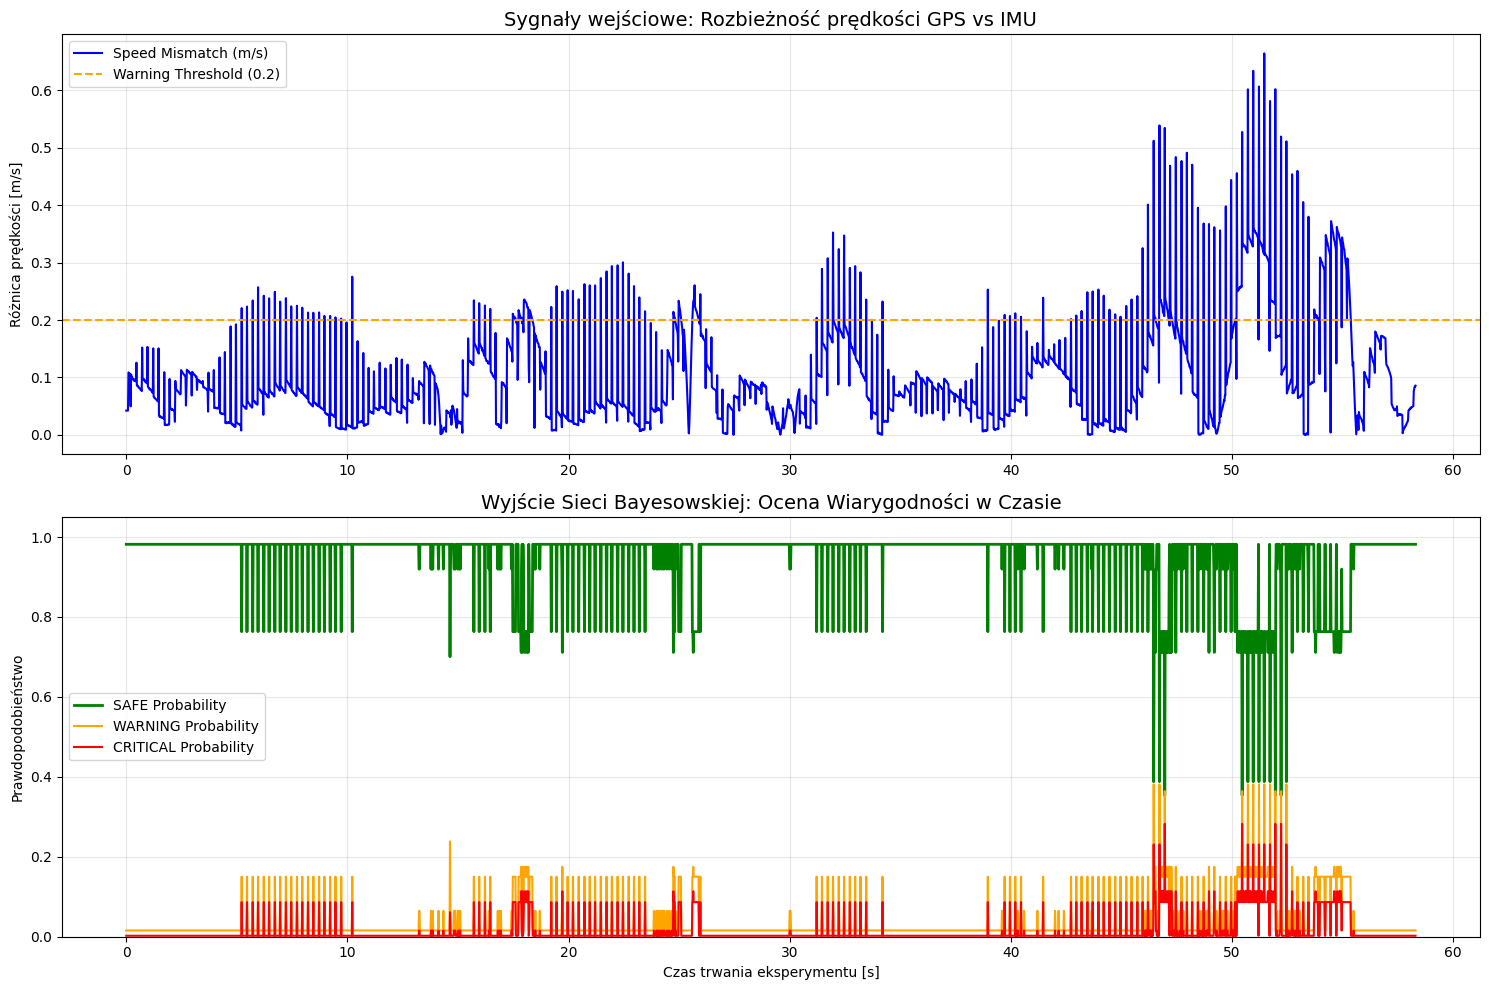

In [42]:
df_bn = pd.DataFrame()

df_bn['Roll_State'] = pd.cut(df_merged['roll'].abs(), 
                             bins=[-1, 5, 15, 180], 
                             labels=[0, 1, 2]).astype(int)

df_bn['Mismatch_State'] = pd.cut(df_merged['speed_mismatch'].abs(), 
                                 bins=[-1, 0.2, 0.5, 100], 
                                 labels=[0, 1, 2]).astype(int)

df_bn['Vibration_State'] = pd.cut((df_merged['acc_total'] - 9.81).abs(),
                                  bins=[-1, 0.5, 2.0, 100], 
                                  labels=[0, 1, 2]).astype(int)

results_safe = []
results_warning = []
results_critical = []

for index, row in tqdm(df_bn.iterrows(), total=df_bn.shape[0]):
    
    evidence = {
        'Mismatch_State': row['Mismatch_State'],
        'Roll_State': row['Roll_State'],
        'Vibration_State': row['Vibration_State']
    }
    
    q = infer.query(variables=['System_Status'], evidence=evidence, show_progress=False)
    
    results_safe.append(q.values[0])
    results_warning.append(q.values[1])
    results_critical.append(q.values[2])

plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
time_rel = df_merged['time'] - df_merged['time'].iloc[0]

plt.plot(time_rel, df_merged['speed_mismatch'], label='Speed Mismatch (m/s)', color='blue')
plt.axhline(y=0.2, color='orange', linestyle='--', label='Warning Threshold (0.2)')
plt.title('Sygnały wejściowe: Rozbieżność prędkości GPS vs IMU', fontsize=14)
plt.ylabel('Różnica prędkości [m/s]')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.plot(time_rel, results_safe, label='SAFE Probability', color='green', linewidth=2)
plt.plot(time_rel, results_warning, label='WARNING Probability', color='orange', linewidth=1.5)
plt.plot(time_rel, results_critical, label='CRITICAL Probability', color='red', linewidth=1.5)

plt.title('Wyjście Sieci Bayesowskiej: Ocena Wiarygodności w Czasie', fontsize=14)
plt.ylabel('Prawdopodobieństwo')
plt.xlabel('Czas trwania eksperymentu [s]')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1.05) 

plt.tight_layout()
plt.savefig('integrity_monitor_results.png')
plt.show()

Zapis wytrenowanego modelu wnioskowania sieci bayesowskiej do pliku w celu późniejszego wykorzystania.

In [43]:
with open('integrity_network.pkl', 'wb') as f:
    pickle.dump(infer, f)